<img style="float: left;" src="./images/cemsf.png" width="100"/><img style="float: right;" src="./images/icons.png" width="500"/>

# Global ECMWF Fire Forecasting

The European Centre for Medium-range Weather Forecasts ([ECMWF](https://www.ecmwf.int/)) produces daily fire danger forecasts and reanalysis products for the Copernicus Emergency Management Services ([CEMS](https://emergency.copernicus.eu/)). Activities are funded funded through a third-party agreement with the European Commission’s Joint Research Centre (JRC).

The modelling system that generates the fire data products is called Global ECMWF Fire Forecast ([GEFF](\href{https://git.ecmwf.int//projects/CEMSF/repos/geff/browse)) and it is based on the Canadian Fire Weather index as well as the US and Australian fire danger systems.

## Data overview

Fire danger data products:

- **GEFF-RT** provides the following *real-time* fire danger forecasts using weather forcings from the latest model cycle of the ECMWF’s Integrated Forecasting System (IFS):
    - *rt_hr*: high-resolution deterministic (~9 Km, with 10 days lead time) and 
    - *rt_en*: lower-resolution probabilistic (~18Km, with 15 days lead time)
- **GEFF-RE** provides historical records of global fire danger conditions (*reanalysis*) from 1980 to the present day. This dataset is updated as soon as new ERA-5 data becomes available (~2 months behind real-time) and it is made of four products:
    - *e5_hr*: deterministic model outputs (~28 Km),
    - *e5_en*: probabilistic model outputs (made of 10 ensemble members, ~56 Km),
    - ensemble mean and
    - ensemble spread.
    
All of GEFF data products are under the Copernicus license, which provides users with free, full and open access to environmental data. Please note, the terms `GEFF data`, `EFFIS data` and `GWIS data` are considered synonyms and will be used interchangibly hereafter.

## Data availability

- **geff-rt** data can be requested through an online [form](https://effis.jrc.ec.europa.eu/applications/data-request-form/) and viewed using the following platforms: the European Forest Fire Information System ([EFFIS](https://effis.jrc.ec.europa.eu/static/effis_current_situation/public/index.html)) and the Global Wildfire Information System ([GWIS](https://gwis.jrc.ec.europa.eu/static/gwis_current_situation/public/index.html))
- **geff-re** is available through the Copernicus Climate Data Store ([CDS](https://cds.climate.copernicus.eu)).

For the purpose of this tutorial, all relevant data is in the directory ./eodata/geff/sweden/

## Event of interest: Sweden fires, 15-20 July 2018

### Background
In the summer of 2018, a large number of wildfires (primarily forest fires) occurred throughout much of Sweden. According to the Swedish Civil Contingencies Agency, they are the most serious in the country in modern history. The summer was unusually warm and dry, significantly raising the risk of fire. Firefighters from multiple countries were involved in fighting the fires. Many people were evacuated from their homes, but there were no fatalities.

Several of the fires were started by people using disposable barbecues, though bans on these were in place due to the weather conditions. Some were started by lightning strikes. Wildfires also occurred in the neighbouring countries Denmark, Finland and Norway, but no casualties due to wildfires were reported in Scandinavia.
(Source: https://en.wikipedia.org/wiki/2018_Sweden_wildfires).

### Active fires
Most of the active fires detected by the MODIS instruments occurred in central-west and north Sewden on 15/20 July.

In [1]:
# First of all, we need to import the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

# Enable inline displaying of plots
%matplotlib inline

In [2]:
# Where did the fire actually occur?
bbox = [10.1, 24.8, 55, 69]
lon_slice = slice(10.1, 24.8)
lat_slice = slice(69, 55)

# Let's download Fire Radiative Power from CAMS GFAS: https://apps.ecmwf.int/datasets/data/cams-gfas/

# Open fire radiative power dataset
ds = xr.open_dataset("./eodata/geff/global/frp/frp_20180701-31.nc")
# Data have global coverage and are bundled in monthly datacubes, we will need to slice in time and space
ds = ds.loc[
    dict(
        time=slice("2018-07-15", "2018-07-20"), longitude=lon_slice, latitude=lat_slice
    )
]
frpfire = ds.frpfire
frpfire.values[frpfire.values <= 0] = np.nan

/usr/lib/python3/dist-packages/xarray/plot/facetgrid.py:273: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


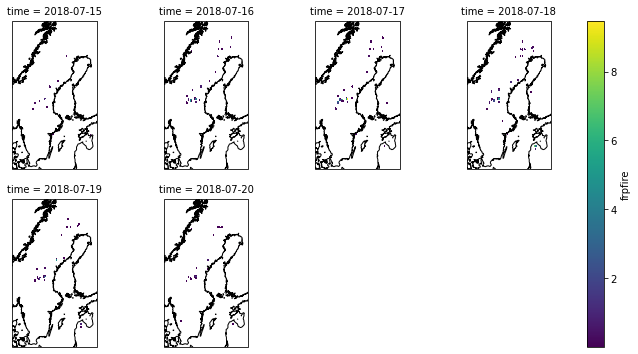

In [3]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=17.45, central_latitude=62)

p = frpfire.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    col="time",
    col_wrap=4,  # multiplot settings
    subplot_kws={"projection": map_proj},
)  # the plot's projection

# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

### Fire Danger Forecasts
Your challege: try to assess fire danger for Sweden fire using GEFF/EFFIS. For convenience, a schematic representation of the forecast issue dates and leadtimes is provided in the table below ([link to spreadsheet](https://docs.google.com/spreadsheets/d/1o-b4i8hiiNF5_I-L4GbBECA01Pf-0bwtPGJH_WzCn-M/edit?usp=sharing)).

![schematic](./images/screenshot-docs.google.com-2020.05.12-08_10_40.png)

## Explore the data

In this section we show how to load GEFF datasets and explore the content. We will touch briefly on the different spatial resolutions of each datasets and related implications (e.g. different land-sea mask -> different spatial coverage).

### geff-rt: fire danger forecasts

The GEFF model uses weather forcings from the ECMWF’s Integrated Forecasting System (IFS) to generate fire danger forecasts. Based on the date of a particular event (e.g. 15-20 July 2018) we can find out what IFS model cycle was used, in this case it was 45r1.

![IFS model cycles](./images/IFS_model_cycles.png)

#### HRES forecast

This dataset provides real-time high-resolution deterministic (~9 Km) fire danger forecasts up to 10 days ahead. Let us explore the content of the sample file.

In [4]:
# Open the dataset
ds_rt_hr = xr.open_dataset("./eodata/geff/global/rt_hr/ECMWF_FWI_20180715_1200_hr.nc")
ds_rt_hr

<xarray.Dataset>
Dimensions:  (lat: 2560, lon: 5120, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-15 2018-07-16 2018-07-17 ...
  * lon      (lon) float32 0.0 0.0703125 0.140625 0.2109375 0.28125 ...
  * lat      (lat) float32 89.94619 89.87648 89.80636 89.736145 89.66589 ...
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Fri May 01 09:30:21 2020: cdo --silent -select,name=fw...
    Conventions:       CF-1.6
    Reference date:    20180715
    ECMWF fire model:  2.2
    Lincense:          Copernicus
    version:           2.2
    NCO:               4.6.7
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

This dataset has three dimensions: latitude, longitude and time. In the lat/long plane data are distributed on a regular grid (2560 x 5120), while the time dimension is made of 10 levels (each corresponds to a daily forecast estimate). Each cell of this datacube contains only 8 variables: fwi, ffmc, dmc, dc, isi, bui, dsr, danger_risk. 

To plot and run basic operations, it is convenient to convert the dataset to a dataarray by extracting 1 variable, e.g. fwi. 

Remember: 
- DataArray = single multi-dimensional variable and its coordinates
- Dataset = holds multiple variables that potentially share the same coordinates.

In [5]:
# Convert ds to a dataarray extracting only the variable fwi
da_rt_hr = ds_rt_hr.fwi
da_rt_hr

<xarray.DataArray 'fwi' (time: 10, lat: 2560, lon: 5120)>
[131072000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-07-15 2018-07-16 2018-07-17 ...
  * lon      (lon) float32 0.0 0.0703125 0.140625 0.2109375 0.28125 ...
  * lat      (lat) float32 89.94619 89.87648 89.80636 89.736145 89.66589 ...
Attributes:
    units:    -
    title:    Fire Weather Index

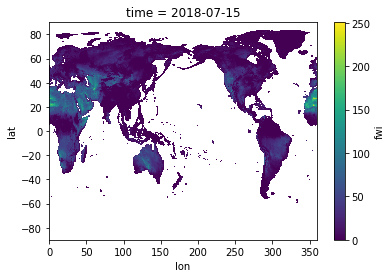

In [6]:
# Plot the first day
da_rt_hr[0].plot()

In [7]:
# Crop over area of interest, note lat = slice(top, bottom), lon = slice(left, right)!
# Use this service to get coordinates: https://boundingbox.klokantech.com/
fwi_rt_hr = da_rt_hr.loc[dict(lat=lat_slice, lon=lon_slice)]

/usr/lib/python3/dist-packages/xarray/plot/facetgrid.py:273: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


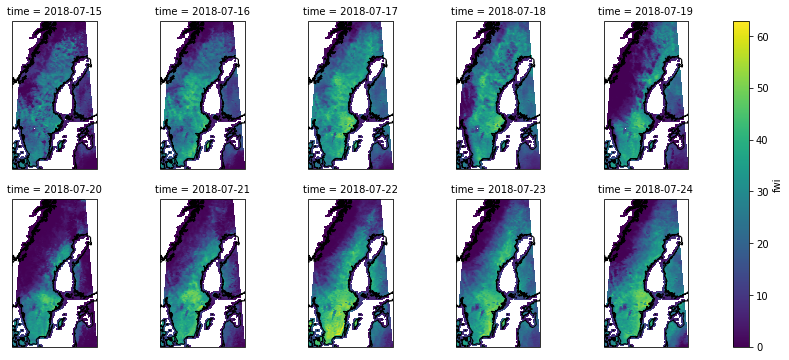

In [8]:
# Plot RT-HR
p = fwi_rt_hr.plot(
    transform=ccrs.PlateCarree(),
    col="time",
    col_wrap=5,
    subplot_kws={"projection": map_proj},
)
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

#### ENS forecast

This dataset provides real-time probabilistic (~18 Km) fire danger forecasts up to 10 days ahead. Each member of the ensemble has similar structure to the HRES but lower resolution.

In [9]:
# Open the dataset
ds_rt_en = xr.open_dataset(
    "./eodata/geff/global/rt_en/ECMWF_FWI_20180715/ECMWF_FWI_20180715_1200_00_fwi.nc"
)
ds_rt_en

<xarray.Dataset>
Dimensions:  (lat: 1280, lon: 2560, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-15 2018-07-16 2018-07-17 ...
  * lon      (lon) float32 0.0 0.140625 0.28125 0.421875 0.5625 0.703125 ...
  * lat      (lat) float32 89.892395 89.753006 89.61279 89.47239 89.33192 ...
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Fri May 01 10:44:39 2020: cdo --silent -select,name=fw...
    Conventions:       CF-1.6
    Reference date:    20180715
    ECMWF fire model:  2.2
    Lincense:          Copernicus
    version:           2.2
    NCO:               4.6.7
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

In [10]:
# Convert ds to a dataarray extracting only the variable fwi
da_rt_en = ds_rt_en.fwi
da_rt_en

<xarray.DataArray 'fwi' (time: 10, lat: 1280, lon: 2560)>
[32768000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-07-15 2018-07-16 2018-07-17 ...
  * lon      (lon) float32 0.0 0.140625 0.28125 0.421875 0.5625 0.703125 ...
  * lat      (lat) float32 89.892395 89.753006 89.61279 89.47239 89.33192 ...
Attributes:
    units:    -
    title:    Fire Weather Index

This dataset is, again, a datacube with three dimensions: latitude, longitude and time. In the lat/long plane data are distributed on a smaller regular grid (1280 x 2560) compared to the HRES forecast.

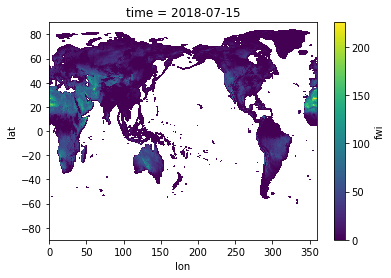

In [11]:
# Plot the first day
da_rt_en[0].plot()

The difference in lower resolution is not evident at this scale, but it will become evident when we explore the same dataset cropped over Sweden.

In [12]:
# Crop over area of interest, note lat = slice(top, bottom), lon = slice(left, right)!
# Use this service to get coordinates: https://boundingbox.klokantech.com/
fwi_rt_en = da_rt_en.loc[dict(lat=lat_slice, lon=lon_slice)]

/usr/lib/python3/dist-packages/xarray/plot/facetgrid.py:273: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


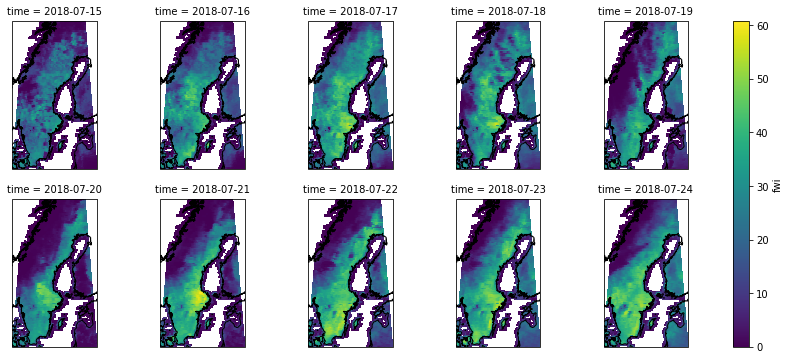

In [13]:
# Plot RT-EN00
p = fwi_rt_en.plot(
    transform=ccrs.PlateCarree(),
    col="time",
    col_wrap=5,
    subplot_kws={"projection": map_proj},
)
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

### geff-re: ERA5 based reanalysis of the Fire Weather Index

This dataset provides historical records of global fire danger conditions from 1980 to the present day and it is made of two main types of products: (i) deterministic model outputs (HRES reanalysis), (ii) probabilistic model outputs (made of 10 ensemble members, ENS reanalysis). It is updated as soon as new ERA5 data becomes available (~2 months behind real-time). 

A single reanalysis layer is often used as proxy for observations (e.g. for validating the forecasts). Stacking together consecutive reanalysis estimates, allows to compute temporal trends and other long term statistics.

#### HRES reanalysis

Let's repeat the same operations shown above, this time the dataset has only 1 temporal layer.
The regular grid is smaller (640 x 1280) compared to the HRES/ENS forecasts.

The example below shows how to explore the single layer reanalysis. Examples of how to use a reanalysis datacube will be shown in follow-up tutorials.

In [14]:
# Open the dataset
ds_e5_hr = xr.open_dataset(
    "./eodata/geff/global/e5_hr/ECMWF_FWI_20180715_1200_hr_fwi_e5.nc"
)
ds_e5_hr

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-15
  * lon      (lon) float32 0.0 0.28125 0.5625 0.84375 1.125 1.40625 1.6875 ...
  * lat      (lat) float32 89.784874 89.5062 89.22588 88.94519 88.66436 ...
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Tue May 12 09:30:52 2020: cdo --silent -select,name=fw...
    Conventions:       CF-1.6
    Reference date:    20180715
    ECMWF fire model:  3.0
    Lincense:          Copernicus
    version:           3.0
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

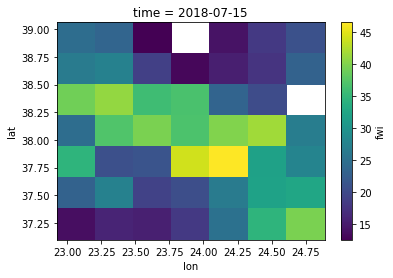

In [15]:
# Convert ds to a dataarray extracting only the variable fwi
da_e5_hr = ds_e5_hr.fwi
fwi_e5_hr = da_e5_hr.loc[dict(lat=slice(39, 37), lon=slice(23, 25))]
fwi_e5_hr[0].plot()

#### ENS reanalysis

Let us repeat the same operations shown above, one last time. The ENS reanalysis dataset of each ensemble member is similar to the HRES reanalysis but the with an even coarser regular grid (320 x 640).

In [16]:
# Open the dataset
ds_e5_en = xr.open_mfdataset(
    "./eodata/geff/global/e5_en/ECMWF_FWI_20180715/ECMWF_FWI_20180715_1200_*_fwi_e5.nc",
    concat_dim="member",
)
ds_e5_en

<xarray.Dataset>
Dimensions:  (lat: 320, lon: 640, member: 10, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-15
  * lon      (lon) float32 0.0 0.5625 1.125 1.6875 2.25 2.8125 3.375 3.9375 ...
  * lat      (lat) float32 89.57009 89.013176 88.45297 87.89203 87.3308 ...
Dimensions without coordinates: member
Data variables:
    fwi      (member, time, lat, lon) float32 dask.array<shape=(10, 1, 320, 640), chunksize=(1, 1, 320, 640)>
Attributes:
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Tue May 12 09:31:38 2020: cdo --silent -select,name=fw...
    Conventions:       CF-1.6
    Reference date:    20180715
    ECMWF fire model:  3.0
    Lincense:          Copernicus
    version:           3.0
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

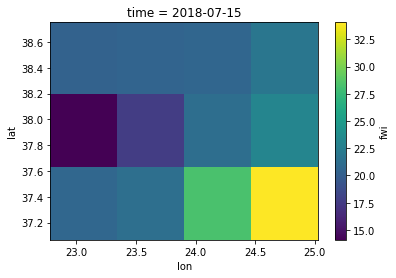

In [17]:
da_e5_en = ds_e5_en.fwi
fwi_e5_en = da_e5_en.loc[dict(lat=slice(39, 37), lon=slice(23, 25))]
fwi_e5_en[0].plot()

To get an idea of how different the 10 ensemble realisations are, we can look are the mean and spread (standard deviation) of the ensemble.

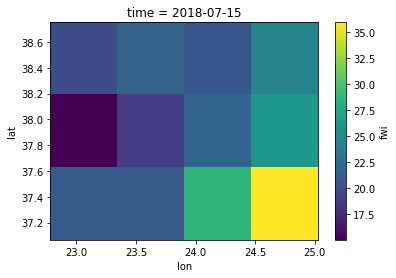

In [18]:
# Calculate mean, then plot
mean_fwi = fwi_e5_en.mean(dim="member")
mean_fwi.plot()

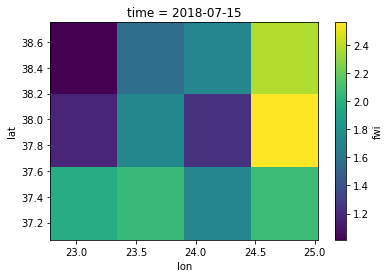

In [19]:
# Calculate spread (standard deviation), then plot
std_fwi = fwi_e5_en.std(dim="member")
std_fwi.plot()

In the next tutorials we will skip over the operations above, as sample data are provided already cropped to the region of interest. Also ensemble mean and spread can be requested directly from the data provider. 